In [1]:
from scipy.io import wavfile
import numpy as np
from ml_tools.utilities import rolling_windows_nd, standardize_data
from ml_tools.models.layers.operators import LatentStack
from ml_tools.models.model_loss import MSELoss
from ml_tools.models.optimizers import SGD
from ml_tools.models.layers.layers import (
    FrequencyFFT,
    FullyConnectedLayer,
    DropoutLayer,
    NormalizeLayer,
)
from ml_tools.models.blocks import FourierAttention
from ml_tools.models.embedding.positional import RopeEmbedding
import matplotlib.pyplot as plt

MAX_POSSIBLE_WINDOWS = 5000

/var/folders/2v/nxc1f8bj0zg_qz_5lqd0w34r0000gn/T/ipykernel_5484/1912526376.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, waveform = wavfile.read(


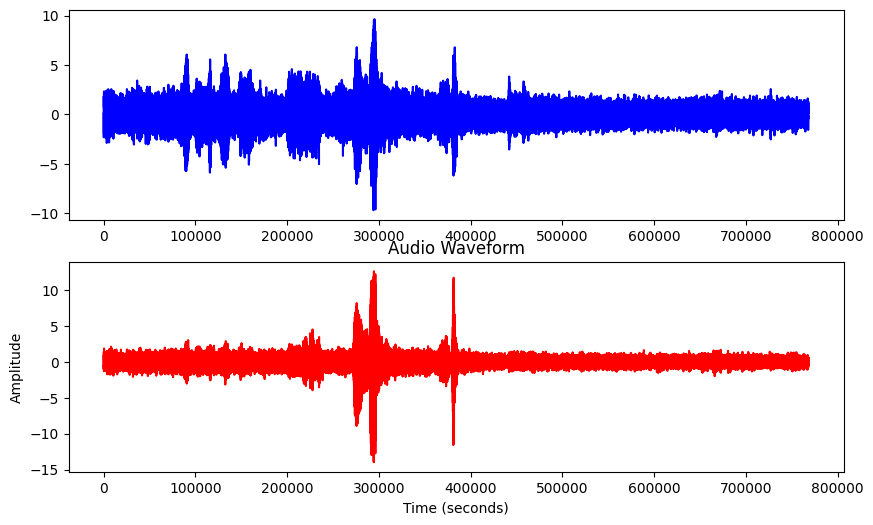

In [2]:
sample_rate, waveform = wavfile.read(
    "/Users/davidanderson/Dropbox/CODE/tools/ml-tools/test.wav"
)

waveform_l, waveform_r = (
    standardize_data(waveform[:, 0]),
    standardize_data(waveform[:, 1]),
)
num_samples = waveform.shape[0]

xs = np.arange(0, num_samples)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(xs, waveform_l, color="blue")
plt.subplot(2, 1, 2)
plt.plot(xs, waveform_r, color="red")
plt.title("Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()


0.010416666666666666 ms per sample step
Each 20 ms window will be composed of 1920 samples


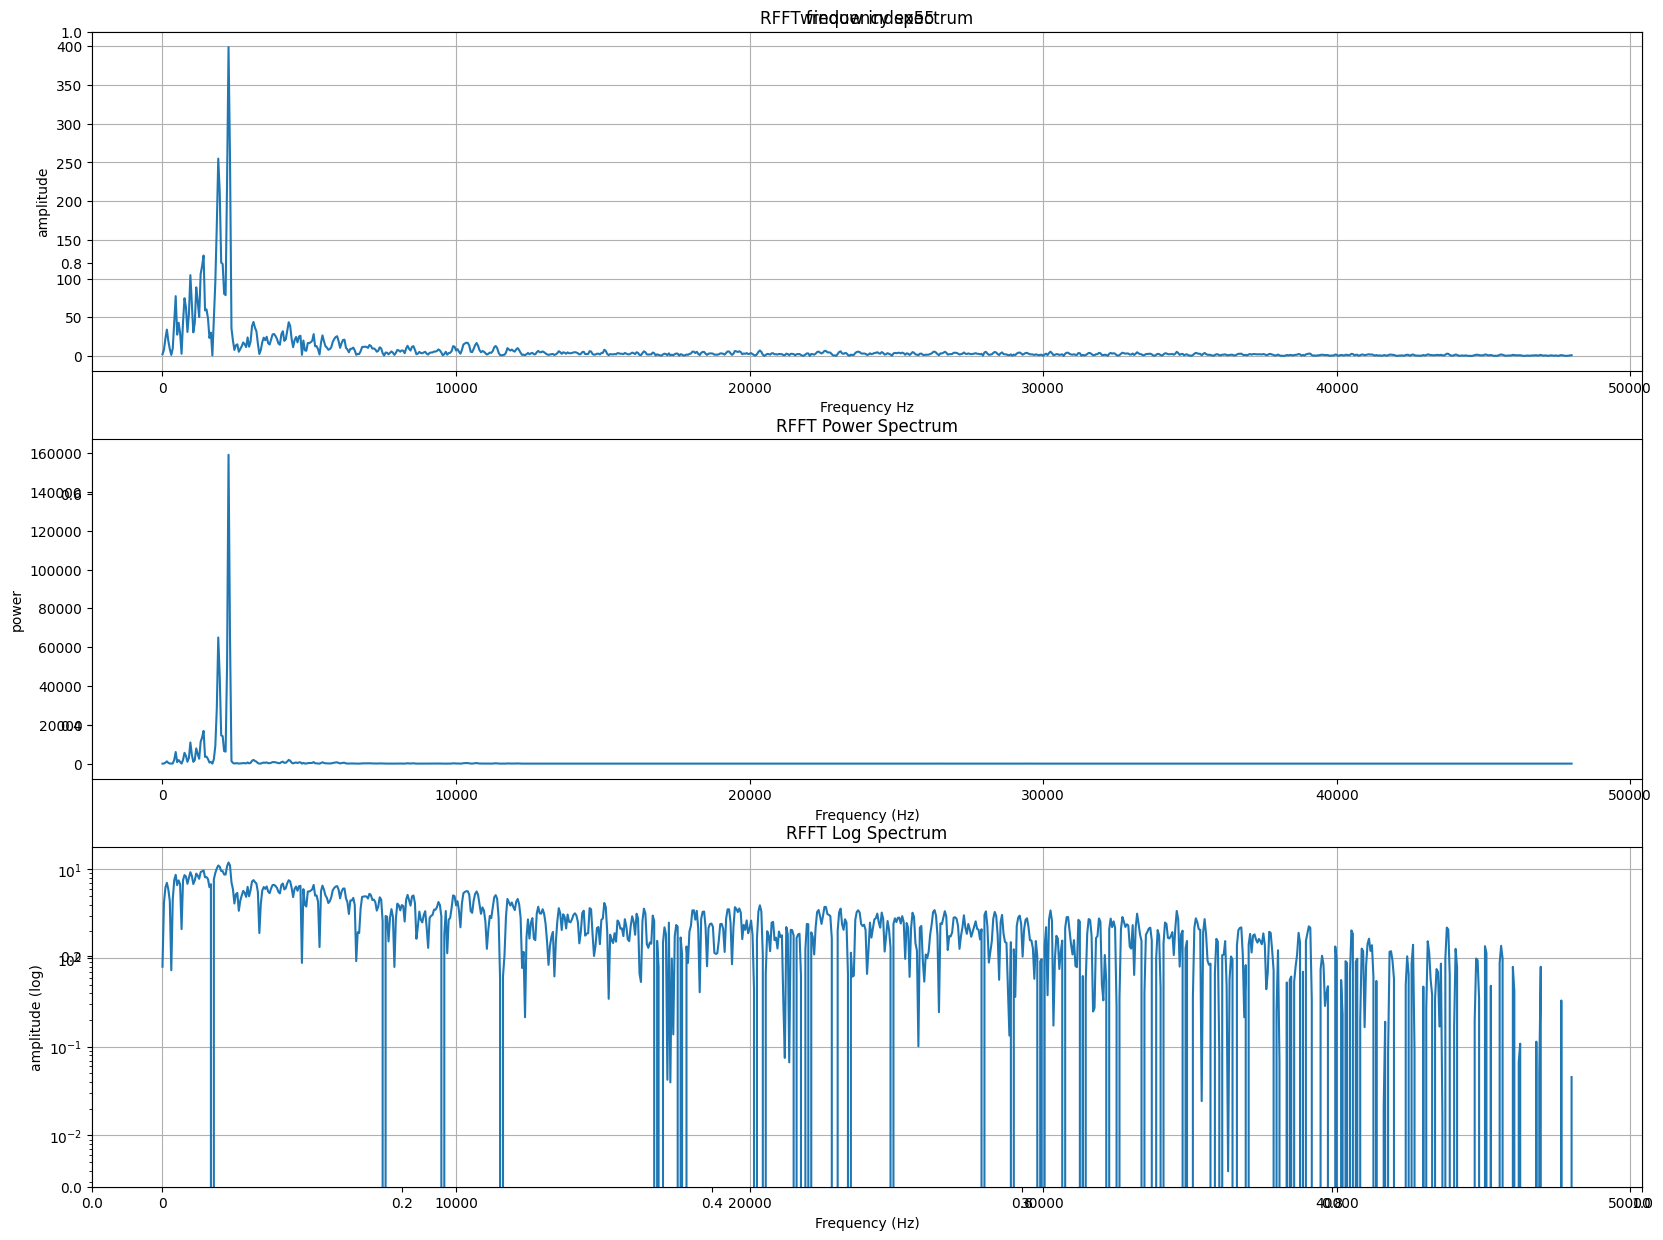

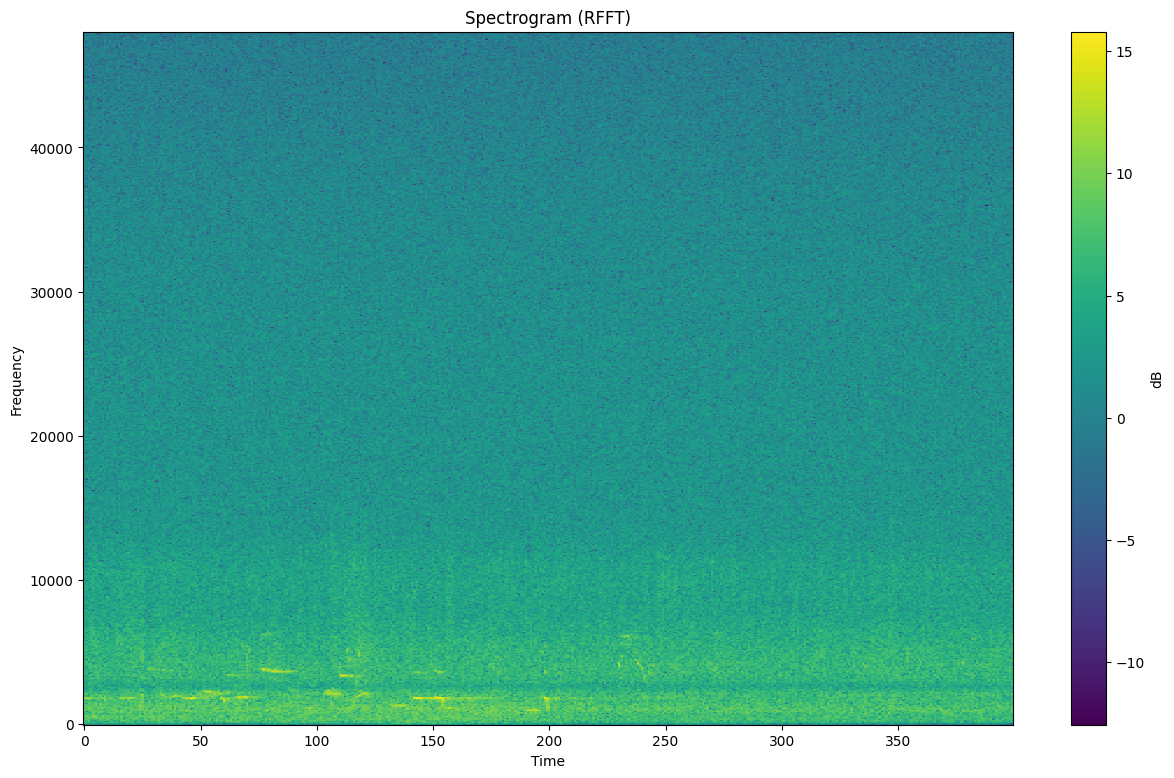

In [3]:

time_per_sample = 1000 / sample_rate
print(time_per_sample, "ms per sample step")

# set window size as ms length ---
window_ms = 20

samples_per_window = int(window_ms / time_per_sample)
print(f"Each {window_ms} ms window will be composed of {samples_per_window} samples")

# now we take windows --
windowed_data = rolling_windows_nd(
    data=waveform_l,
    window_size=samples_per_window,
    num_overlap=samples_per_window // 3,
    axis=0,
)

# window count, sample_steps
num_windows, _samp = windowed_data.shape
assert _samp == samples_per_window


windowed_spectrogram = []
window = np.blackman(samples_per_window)
# junky workaround so we don't have to fancy-reindex.
for i in range(num_windows):
    start, end = i * samples_per_window, (i * samples_per_window + samples_per_window)
    # junky workaround so we don't have to fancy-reindex.
    if end > waveform_l.size:
        break

    kernel = waveform_l[start:end] * window

    xs = np.fft.rfft(kernel)
    magnitude = np.abs(xs)
    windowed_spectrogram.append(magnitude)

windowed_spectrogram = np.vstack(windowed_spectrogram)

freqs = np.fft.rfftfreq(samples_per_window, d=1.0 / sample_rate)
# magnitude = np.abs(windowed_data) / samples_per_window
# square all except DC (0 idx and representing zero hertz) and Nyquist (-1 position)
power_spectrogram = windowed_spectrogram.copy()
power_spectrogram[:, 1:-1] = power_spectrogram[:, 1:-1] ** 2
# square to power, log to decibels (log10?)
windowed_decibel_spectrogram = np.log(power_spectrogram + 1e-12)

time_axis = np.arange(windowed_decibel_spectrogram.shape[0])

idx = 55
plt.figure(figsize=(20, 15))
plt.title(f"window index{idx}")
plt.subplot(3, 1, 1)
plt.plot(freqs, windowed_spectrogram[idx, :])
plt.xlabel("Frequency Hz")
plt.ylabel("amplitude")
plt.title("RFFT frequency spectrum")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(freqs, power_spectrogram[idx, :])
plt.xlabel("Frequency (Hz)")
plt.ylabel("power")
plt.title("RFFT Power Spectrum")

plt.subplot(3, 1, 3)
plt.semilogy(freqs, windowed_decibel_spectrogram[idx, :])
plt.xlabel("Frequency (Hz)")
plt.ylabel("amplitude (log)")
plt.title("RFFT Log Spectrum")
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 9))
plt.pcolormesh(time_axis, freqs, windowed_decibel_spectrogram.T, shading="auto")

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Spectrogram (RFFT)")
plt.colorbar(label="dB")
plt.show()


In [6]:
#  FFT will output a shape of n//2 + 1.
real_positive_fft_shape = (samples_per_window // 2) + 1

# project dimensions down to half - this should be enough to keep our calculations
# limited without losing too much grainularity in the data.
LATENT_DIMENSION = int(real_positive_fft_shape * 0.75)


# AMPLITUDE ------------------------------------------------------------------
# FUNNEL PROJECTION -->
# dimensional reduction in Feed Forward, built of 1-4 stacked layers
# this gives us a weighted amplitude
# Project down to real_positive_fft_shape? OR LATENT_DIMENSION
# (1920, 1080,   real_positive_fft_shape)
amplitude_layer_a = FullyConnectedLayer(
    ni=samples_per_window, no=1200, activation_type="relu", is_output=False
)
amplitude_layer_b = FullyConnectedLayer(
    ni=1200, no=real_positive_fft_shape, activation_type="relu",
    is_output=False
)
amplitude_layer_c = FullyConnectedLayer(
    ni=real_positive_fft_shape,
    no=LATENT_DIMENSION,
    activation_type="tanh",
    is_output=True,
)


# FREQUENCY -----------------------------------------------------------------
# real positive only FFT: np rfft process -> final shape of FFT transform is  n//2 + 1.
# transformed_data = np.fft.rfft(windowed_data, axis=-1)
freq_fft_layer = FrequencyFFT(
    max_sequence_length=MAX_POSSIBLE_WINDOWS, window_size=samples_per_window
)
freq_fc_layer = FullyConnectedLayer(
    ni=real_positive_fft_shape,
    no=LATENT_DIMENSION,
    activation_type="tanh",
    is_output=True,
)

# Feed Forward, built of 1-3 stacked layers?
stacking_layer = LatentStack()

# Rotary Positional embedding - (relative position and distances -------------
rope_layer = RopeEmbedding(
    sequence_length=MAX_POSSIBLE_WINDOWS, embedding_dimension=2 * LATENT_DIMENSION
)

enc_attention = FourierAttention(
    ni=2 * LATENT_DIMENSION, no=2 * LATENT_DIMENSION, use_2d=True
)


EMBEDDING_DIM = 720
# feed froward--
FC_IN = 2 * LATENT_DIMENSION
dropout_a = DropoutLayer(dropout_prob=0.05)
fc_a = FullyConnectedLayer(ni=FC_IN, no=1200, activation_type="relu",
                           is_output=False)
fc_b = FullyConnectedLayer(ni=1200, no=900, activation_type="relu",
                           is_output=False)
fc_c = FullyConnectedLayer(
    ni=900, no=EMBEDDING_DIM, activation_type="tanh", is_output=True
)


# And Finally, we're at the latent space embedding ------------------------
# NOW WE CAN SEND THE LATENT EMBEDDING INTO our Kernel FourierNetwork.
# the feature encoding and Kernel FourierNetwork layers out into the model's embedding - latent space.

decoder_dropout = DropoutLayer(dropout_prob=0.05)
decoder_attention = FourierAttention(ni=EMBEDDING_DIM, no=EMBEDDING_DIM, use_2d=True)
decoder_fc_a = FullyConnectedLayer(
    ni=EMBEDDING_DIM, no=1200, activation_type="relu", is_output=False
)
decoder_fc_b = FullyConnectedLayer(
    ni=1200, no=samples_per_window, activation_type="relu", is_output=False
)
decoder_norm = NormalizeLayer(ni=samples_per_window, shift_scale=True)

# rescaling layer
decoder_fc_c = FullyConnectedLayer(
    ni=samples_per_window,
    no=samples_per_window,
    activation_type="linear",
    is_output=True,
)

loss = MSELoss()
optimizer = SGD(0.001)
# assert (decoder_output.shape == (num_windows, samples_per_window))
# REBUILD windowed_data
# reconstruction error = winodw_data - decoder output


# now let's do some fitting ---
all_losses = []
all_layers = [amplitude_layer_a, amplitude_layer_b, amplitude_layer_c, freq_fft_layer, freq_fc_layer,
              stacking_layer, rope_layer, enc_attention, dropout_a, fc_a, fc_b, fc_c, decoder_dropout,
              decoder_attention, decoder_fc_a, decoder_fc_b, decoder_norm, decoder_fc_c,]

# Training ----


at this stage, we've output a model recreation of encoder-decoder process. x_prime (model output) is (599, 1920) compared to the original (599, 1920)
reconstruction loss is at 0.998185972917573
decoder_net backpass (599, 720)
embedding_net backpass (599, 1440)
rope_layer backpass (599, 1440)
stacking backpass (599, 720), freq_grad.shape


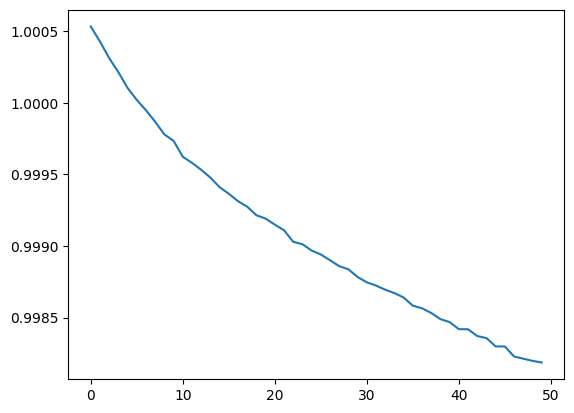

KeyboardInterrupt: 

In [7]:
for step in range(5000):
    verbose = True if (step + 1) % 50 == 0 else False

    # -------------------- FORWARD PASS THROUGH THE NETWORK ------------
    x_amp = amplitude_layer_c(amplitude_layer_b(amplitude_layer_a(windowed_data)))
    x_freq = freq_fc_layer(freq_fft_layer(windowed_data))
    x_stacked = rope_layer(stacking_layer(x_amp, x_freq))
    encoded = fc_c(fc_b(fc_a(dropout_a(enc_attention(x_stacked)))))

    x_prime = decoder_fc_c(
        decoder_norm(
            decoder_fc_b(
                decoder_fc_a(
                    decoder_attention(
                        decoder_dropout(encoded))))
        )
    )

    assert x_prime.shape == (num_windows, samples_per_window)

    _l = loss.forward(prediction=x_prime, targets=windowed_data)
    if verbose:
        print(
            f"at this stage, we've output a model recreation of encoder-decoder process."
            f" x_prime (model output) is {x_prime.shape} compared to the original {windowed_data.shape}"
        )
        print(f"reconstruction loss is at {_l}")
    all_losses.append(_l.item())

    # -------------------- backwards pass --------------------
    grad_output = loss.backward()

    grad_output = decoder_dropout.backward(
        decoder_attention.backward(
            decoder_fc_a.backward(
                decoder_fc_b.backward(
                    decoder_norm.backward(
                        decoder_fc_c.backward(grad_output)
                    )
                )
            )
        )
    )
    if verbose:
        print(f"decoder_net backpass {grad_output.shape}")

    grad_output = enc_attention.backward(
        dropout_a.backward(
            fc_a.backward(
                fc_b.backward(
                    fc_c.backward(grad_output)
                )
            )
        )
    )
    if verbose:
        print(f"embedding_net backpass {grad_output.shape}")
    grad_output = rope_layer.backward(grad_output)
    if verbose:
        print(f"rope_layer backpass {grad_output.shape}")
    amp_grad, freq_grad = stacking_layer.backward(grad_output)
    if verbose:
        print(f"stacking backpass {amp_grad.shape}, freq_grad.shape")

    amp_grad = amplitude_layer_c.backward(amp_grad)
    amp_grad = amplitude_layer_b.backward(amp_grad)
    amp_grad = amplitude_layer_a.backward(amp_grad)
    freq_out = freq_fft_layer.backward(freq_fc_layer.backward(freq_grad))

    optimizer.step(all_layers)

    if verbose:
        plt.plot(all_losses)
        plt.show()

print(all_losses)
plt.plot(all_losses)
plt.show()